In [19]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [20]:
env = BlackjackEnv()

In [41]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))
Q

defaultdict(<function __main__.<lambda>()>, {})

In [21]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA)
        a_star_action = np.argmax(Q[observation])
        
        for i in range(nA):
            if i == a_star_action:
                A[i] = 1 - epsilon + epsilon/nA
                continue
            A[i] = epsilon/nA
        return A
                
        
        
    return policy_fn

In [37]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    
    for iter_ in range(num_episodes):
        if iter_%10000 == 0:
            print(iter_)
        #Generate an episode following policy
        observation = env.reset()
        episode = []
        while True:
            probability = policy(observation)
            action = np.random.choice(np.arange(env.action_space.n),p = probability)
            next_observation, reward, done, _ = env.step(action)
            episode.append((observation, reward,action))
            
            if done:
                break
                
            observation = next_observation
            
            
        episode_list = set([(x[0],x[2]) for x in episode])
        
        for st,action in episode_list:
            first_occurence = next(i for i,j in enumerate(episode) if j[0] == st and j[2] == action)
            sum_upto_last = sum([i[1] for i in episode[first_occurence:]])
            returns_sum[(st,action)]+=sum_upto_last
            returns_count[(st,action)]+=1
            
            Q[st][action] = returns_sum[(st,action)]/returns_count[(st,action)]
        
        
    
    # Implement this!
    
    return Q, policy

In [38]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, epsilon=0.1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


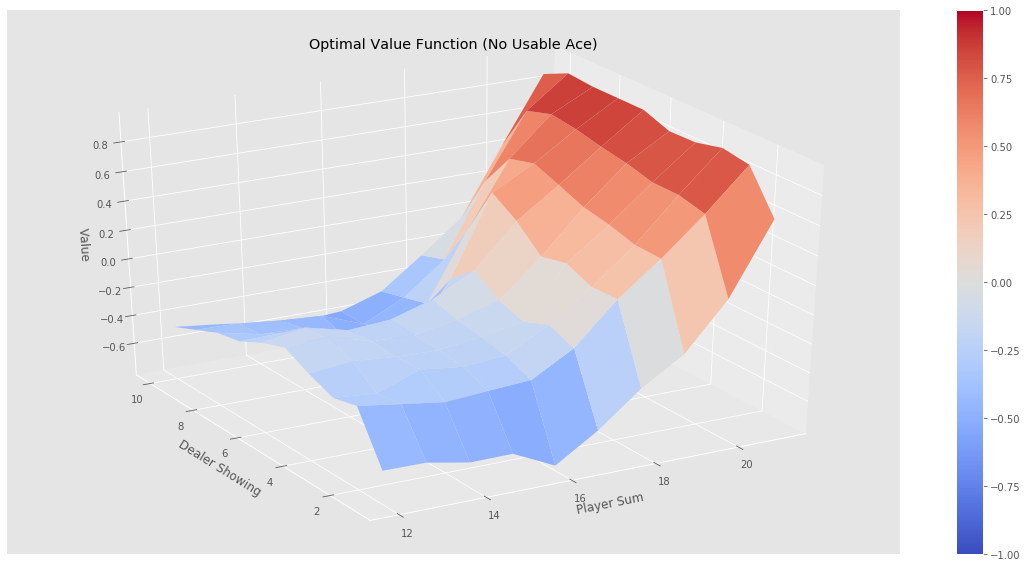

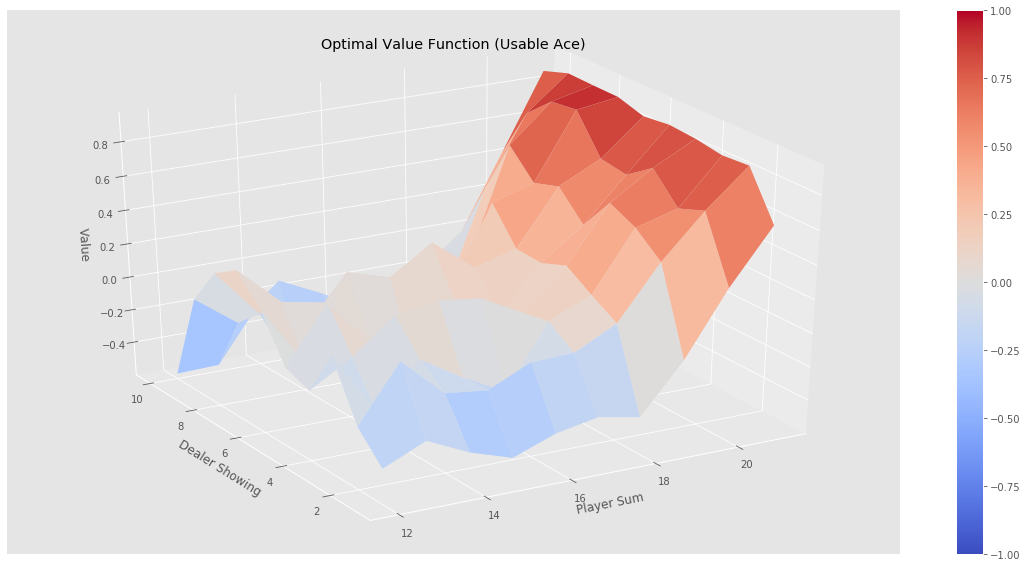

In [39]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")